In [0]:
#Change to working directory
%cd /content/drive/Shared\ drives/CS230 
%cd google_action_recognition_trial

/content/drive/Shared drives/CS230
/content/drive/Shared drives/CS230/google_action_recognition_trial


In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv3D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Reshape,AveragePooling3D, Bidirectional, LSTM, TimeDistributed, Lambda, Concatenate
from keras.models import Model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils import plot_model
from keras.initializers import VarianceScaling
from keras.backend import mean
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import os

from scipy.special import softmax
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
#function for one hot label generation
def to_one_hot(labels):
  output = np.zeros(( np.size(labels),6 ))
  label_dict = {'backhand':0,'forehand':1, 'bvolley':2, 'fvolley':3, 'smash':4, 'service':5}
  for n in np.arange(np.size(labels)):
    label = labels[n]
    output[n, label_dict[label]] = 1
  return output 

In [0]:
#helper functions
import csv

def create_data(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2046])
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/0/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2046)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1

  with h5py.File(dataset+'.hdf5', 'w') as f:
    write_data = f.create_dataset('X', np.shape(data))
    write_data[:] = data 

def load_labels(dataset='train',size=20):
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:  
        labels.append(row[1])
        i+=1
  return to_one_hot(labels)

def load_data(size_whole,dataset='train'):
  with h5py.File(dataset+'_1.hdf5', 'r') as f:
    data = np.array(f['X'])
    size = data.shape[0]
  labels_one_hot = load_labels(dataset=dataset,size=size)

  return data[:size_whole], labels_one_hot[:size_whole]


def create_small_dataset(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2046])
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/0/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2046)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1
  return data, to_one_hot(labels)

In [0]:
#load datasets
X_train, Y_train = load_data(size_whole=1584,dataset='train')
X_val, Y_val = load_data(size_whole=204,dataset='validation')
X_test, Y_test = load_data(size_whole=192,dataset='test')

In [0]:
# Train network
dropout_rate=0.3
m=0.01
def model_instance(input_shape):
  X_input = Input(shape = input_shape)
  X = Conv3D(32,kernel_size=(1,7,7), padding='valid',kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal'))(X_input)
  #,kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal')  
  X = Reshape((32,))(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  X = BatchNormalization(momentum=m)(X)
  preds = Activation("softmax")(X)
  model = Model(inputs=X_input, outputs=preds)
  return model 
model = model_instance(input_shape=(1,7,7,2048))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 7, 7, 2048)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 1, 32)       3211296   
_________________________________________________________________
reshape_3 (Reshape)          (None, 32)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________

In [0]:
if not os.path.exists('Checkpoints'):
    os.mkdir('Checkpoints')
opt=Adam(lr=0.01)
checkpoint = ModelCheckpoint(os.path.join('Checkpoints','shallow_model_1_final_d03m01.hdf5'), monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model.fit(X_train, Y_train, epochs = 500, batch_size=128,callbacks=[checkpoint],validation_data=(X_val,Y_val), shuffle=True, validation_freq=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1584 samples, validate on 204 samples
Epoch 1/500





1584/1584 [==============================] - 11s 7ms/step - loss: 1.8062 - categorical_accuracy: 0.2816 - val_loss: 1.6036 - val_categorical_accuracy: 0.3431

Epoch 00001: val_categorical_accuracy improved from -inf to 0.34314, saving model to Checkpoints/shallow_model_1_final_d03m01.hdf5
Epoch 2/500
1584/1584 [==============================] - 0s 273us/step - loss: 1.5572 - categorical_accuracy: 0.3876 - val_loss: 1.5212 - val_categorical_accuracy: 0.4265

Epoch 00002: val_categorical_accuracy improved from 0.34314 to 0.42647, saving model to Checkpoints/shallow_model_1_final_d03m01.hdf5
Epoch 3/500
1584/1584 [==============================] - 0s 280us/step - loss: 1.4710 - categorical_accuracy: 0.4343 - val_loss: 1.4754 - val_categorical_accuracy: 0.4167

Epoch 00003: val_categorical_accuracy did not improve from 0.42647
Epoc

In [0]:
opt=Adam(lr=0.01)
model.load_weights(os.path.join('Checkpoints','shallow_model_1_final_d03m01.hdf5'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.evaluate(X_train,Y_train))
print(model.evaluate(X_val,Y_val))
print(model.evaluate(X_test,Y_test))

1584/1584 [==============================] - 0s 284us/step
[0.007219610369036378, 0.9987373737373737]
204/204 [==============================] - 0s 246us/step
[1.0326167812534408, 0.7990196066744187]
192/192 [==============================] - 0s 255us/step
[1.0421044826507568, 0.8020833333333334]


In [0]:
Y_probs_1=model.predict(X_test)
Y_pred_1=softmax(Y_probs_1,axis=-1)
Y_fortesting=np.argmax(Y_pred_1,axis=-1)
accuracy_score(np.argmax(Y_test,axis=1),Y_fortesting)

0.8020833333333334

In [0]:
target_names = ['backhand', 'forehand', 'bvolley', 'fvolley', 
                   'smash', 'service']
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(np.argmax(Y_test,axis=1), Y_fortesting, target_names=target_names))
conf_matrix = confusion_matrix(np.argmax(Y_test,axis=1), Y_fortesting)

              precision    recall  f1-score   support

    backhand       0.82      0.88      0.85        48
    forehand       0.74      0.81      0.77        48
     bvolley       0.88      0.88      0.88        16
     fvolley       0.75      0.56      0.64        16
       smash       0.67      0.38      0.48        16
     service       0.86      0.92      0.89        48

    accuracy                           0.80       192
   macro avg       0.79      0.74      0.75       192
weighted avg       0.80      0.80      0.79       192



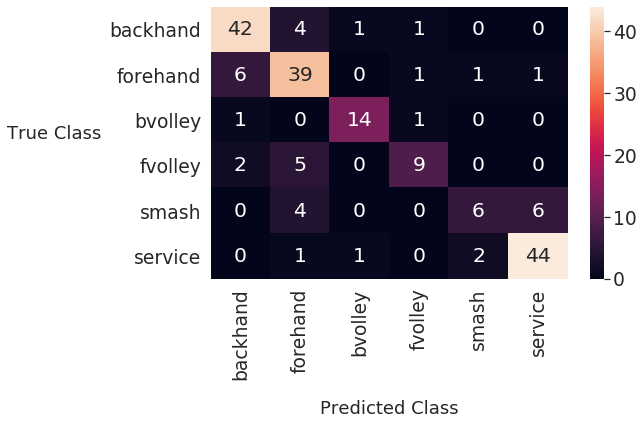

In [0]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.7)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (8,5))
ax = sns.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted Class', fontsize=18, labelpad=20)
ax.set_ylabel('True Class', fontsize=18, rotation=0, labelpad=55)
plt.savefig('confusion_matrix_1_shallow_new.jpg', bbox_inches = 'tight')
plt.show()

#Model 0

In [0]:
import csv

def create_data(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2046])
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/0/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2046)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1

  with h5py.File(dataset+'.hdf5', 'w') as f:
    write_data = f.create_dataset('X', np.shape(data))
    write_data[:] = data 

def load_labels(dataset='train',size=20):
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:  
        labels.append(row[1])
        i+=1
  return to_one_hot(labels)

def load_data(size_whole,dataset='train'):
  with h5py.File(dataset+'.hdf5', 'r') as f:
    data = np.array(f['X'])
    size = data.shape[0]
  labels_one_hot = load_labels(dataset=dataset,size=size)

  return data[:size_whole], labels_one_hot[:size_whole]


def create_small_dataset(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2046])
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/0/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2046)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1
  return data, to_one_hot(labels)

In [0]:
X_train, Y_train = load_data(size_whole=1584,dataset='train')
X_val, Y_val = load_data(size_whole=204,dataset='validation')
X_test, Y_test = load_data(size_whole=192,dataset='test')

In [0]:
# Train network
dropout_rate=0.3
m=0.01
def model_instance(input_shape):
  X_input = Input(shape = input_shape)
  X = Conv3D(32,kernel_size=(1,7,7), padding='valid',kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal'))(X_input)
  #,kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal')  
  X = Reshape((32,))(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  X = BatchNormalization(momentum=m)(X)
  """
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(64)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(32)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  """
  preds = Activation("softmax")(X)
  model = Model(inputs=X_input, outputs=preds)
  return model 
model = model_instance(input_shape=(1,7,7,2046))
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 7, 7, 2046)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 1, 1, 1, 32)       3208160   
_________________________________________________________________
reshape_5 (Reshape)          (None, 32)                0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
activation_7 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198 

In [0]:
if not os.path.exists('Checkpoints'):
    os.mkdir('Checkpoints')
opt=Adam(lr=0.01)
checkpoint = ModelCheckpoint(os.path.join('Checkpoints','shallow_model_0_final_d03m01.hdf5'), monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model.fit(X_train, Y_train, epochs = 500, batch_size=128,callbacks=[checkpoint],validation_data=(X_val,Y_val), shuffle=True, validation_freq=1)

Train on 1584 samples, validate on 204 samples
Epoch 1/500
1584/1584 [==============================] - 0s 280us/step - loss: 0.5066 - categorical_accuracy: 0.8087 - val_loss: 1.1699 - val_categorical_accuracy: 0.5882

Epoch 00001: val_categorical_accuracy did not improve from 0.72549
Epoch 2/500
1584/1584 [==============================] - 0s 279us/step - loss: 0.5019 - categorical_accuracy: 0.8005 - val_loss: 1.5268 - val_categorical_accuracy: 0.5441

Epoch 00002: val_categorical_accuracy did not improve from 0.72549
Epoch 3/500
1584/1584 [==============================] - 0s 290us/step - loss: 0.5084 - categorical_accuracy: 0.8030 - val_loss: 1.8561 - val_categorical_accuracy: 0.5049

Epoch 00003: val_categorical_accuracy did not improve from 0.72549
Epoch 4/500
1584/1584 [==============================] - 0s 279us/step - loss: 0.5651 - categorical_accuracy: 0.7784 - val_loss: 1.1607 - val_categorical_accuracy: 0.5882

Epoch 00004: val_categorical_accuracy did not improve from 0.725

In [0]:
opt=Adam(lr=0.01)
model.load_weights(os.path.join('Checkpoints','shallow_model_0_final_d03m01.hdf5'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.evaluate(X_train,Y_train))
print(model.evaluate(X_val,Y_val))
print(model.evaluate(X_test,Y_test))

1584/1584 [==============================] - 1s 330us/step
[0.2167185383914697, 0.9160353535353535]
204/204 [==============================] - 0s 200us/step
[0.8569748354893104, 0.7352941176470589]
192/192 [==============================] - 0s 206us/step
[0.8352991739908854, 0.71875]


In [0]:
Y_probs_1=model.predict(X_test)
Y_pred_1=softmax(Y_probs_1,axis=-1)
Y_fortesting=np.argmax(Y_pred_1,axis=-1)
accuracy_score(np.argmax(Y_test,axis=1),Y_fortesting)

0.71875

In [0]:
target_names = ['backhand', 'forehand', 'bvolley', 'fvolley', 
                   'smash', 'service']
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(np.argmax(Y_test,axis=1), Y_fortesting, target_names=target_names))
conf_matrix = confusion_matrix(np.argmax(Y_test,axis=1), Y_fortesting)

              precision    recall  f1-score   support

    backhand       0.72      0.81      0.76        48
    forehand       0.69      0.75      0.72        48
     bvolley       1.00      0.44      0.61        16
     fvolley       1.00      0.50      0.67        16
       smash       0.57      0.25      0.35        16
     service       0.69      0.92      0.79        48

    accuracy                           0.72       192
   macro avg       0.78      0.61      0.65       192
weighted avg       0.74      0.72      0.70       192



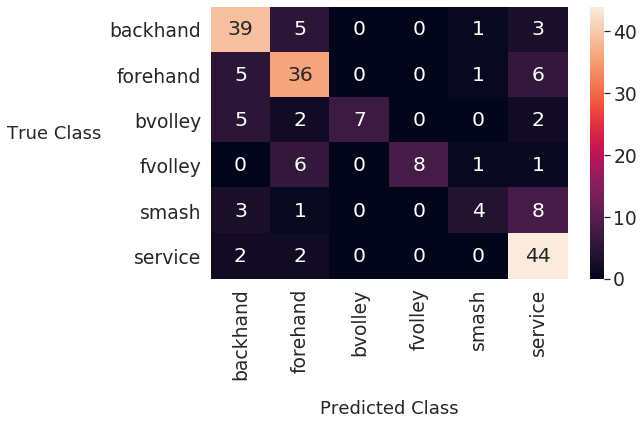

In [0]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.7)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (8,5))
ax = sns.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted Class', fontsize=18, labelpad=20)
ax.set_ylabel('True Class', fontsize=18, rotation=0, labelpad=55)
plt.savefig('confusion_matrix_0_shallow_new.jpg', bbox_inches = 'tight')
plt.show()